In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#from tkn import TKN
import tkn
import models

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.5.0-dev20201027
Num GPUs Available:  1


(1, 50, 512)


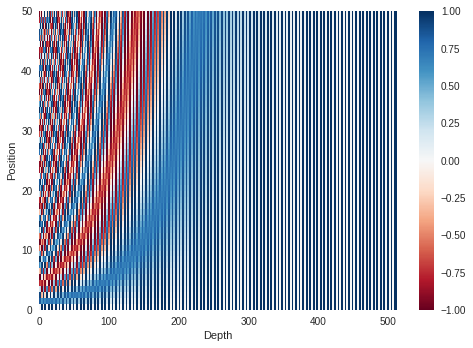

In [2]:
# Positional Encoding Demo

pos_encoding = tkn.positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [3]:
# Attention Demo
def print_out(q, k, v):
  temp_out, temp_attn = tkn.scaled_dot_product_attention(
      q, k, v)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

print("#"*100)

temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
####################################################################################################
Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [4]:
#Multi-headed attention demo

temp_mha = tkn.MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [5]:
#TKNLayer demo

sample_encoder_layer = tkn.TKNLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [6]:
num_layers = 2
d_model = 8
dff = 128
num_heads = 4

dropout_rate = 0.01

In [7]:
#CUSTOM ADAM BASED ON https://arxiv.org/abs/1706.03762
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [8]:
learning_rate = CustomSchedule(d_model, warmup_steps=10)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [9]:
model = models.TKN_Basic(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, input_dim=4, output_dim=2,
              maximum_position_encoding=5000, rate=dropout_rate)

In [10]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

#if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [11]:
data_path = '~/data/cd560d6ec65c4e79.csv'

#TODO: get data and read more data
# df = pd.read_csv(data_path, delimiter=',', usecols=['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK', 'ASKSIZ', 'SYM_ROOT'],skiprows=[i for i in range(1,200000)], nrows=1000000)
df = pd.read_csv(data_path, delimiter=',', usecols=['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK', 'ASKSIZ', 'SYM_ROOT'],skiprows=[i for i in range(1,200000)], nrows=10000)


# Replace 0 to avoid dividing by 0 later on
# TODO: SHOULD USE FFILL, but doesn't work if first entry is 0
# or IDEALLY, USE SOME METHOD TO INDICATE VOLUME IS 0
df['BID'].replace(to_replace=0, method='bfill', inplace=True)
df['ASK'].replace(to_replace=0, method='bfill', inplace=True)
df['BIDSIZ'].replace(to_replace=0, method='bfill', inplace=True)
df['ASKSIZ'].replace(to_replace=0, method='bfill', inplace=True)
df.sort_values(by=['DATE', 'TIME_M'], inplace=True)

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
#TODO: remove rolling mean
df[['BID', 'BIDSIZ', 'ASK', 'ASKSIZ']] = df[['BID', 'BIDSIZ', 'ASK', 'ASKSIZ']].rolling(1000).mean() 
df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

In [12]:
'''Calculate percentage change'''
df2 = df[:]
df2['BID'] = df['BID']
df2['BID'].pct_change()

df2['BIDSIZ'] = df['BIDSIZ']
df2['BIDSIZ'].pct_change()
df2['ASK'] = df['ASK']
df2['ASK'].pct_change()
df2['ASKSIZ'] = df['ASKSIZ']
df2['ASKSIZ'].pct_change()

df2.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

'''Create training, validation and test split'''

# Remove date, time, symbol column
df2.drop(columns=['DATE'], inplace=True)
df2.drop(columns=['TIME_M'], inplace=True)
df2.drop(columns=['SYM_ROOT'], inplace=True)


In [13]:
test_data=df2.values
seq_len=512

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append([test_data[i][0], test_data[i][2]])  
X_test, y_test = np.array(X_test), np.array(y_test)

print('Testing set shape' ,X_test.shape, y_test.shape)

Testing set shape (8489, 512, 4) (8489, 2)


In [21]:
test_pred = model.predict(X_test)
test_pred

array([[0.5090375 , 0.5017521 ],
       [0.50903744, 0.50175214],
       [0.50903744, 0.5017521 ],
       ...,
       [0.50903755, 0.5017521 ],
       [0.5090375 , 0.50175214],
       [0.50903755, 0.50175214]], dtype=float32)

In [22]:
# init = df['BID'].values[seq_len]
# print(init)
# test_pred[0] = init * (1 + test_pred[0][0])

# for i in range(len(test_pred) - 1):
#     test_pred[i+1] = test_pred[i] * (test_pred[i+1][0] * -2.069932899528837e-06 + 1)

actual = df['BID'].values

for i in range(len(test_pred)):
    perc = 0.03565092526477698 * (test_pred[i] - .5)
    print(perc)
    test_pred[i] = actual[i] * (1 + perc)

[0.0003222  0.00006246]
[0.00032219 0.00006247]
[0.00032219 0.00006246]
[0.00032219 0.00006246]
[0.00032219 0.00006246]
[0.0003222  0.00006246]
[0.00032219 0.00006247]
[0.0003222  0.00006246]
[0.00032219 0.00006246]
[0.0003222  0.00006246]
[0.00032219 0.00006246]
[0.00032219 0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.00032219 0.00006246]
[0.00032219 0.00006247]
[0.0003222  0.00006246]
[0.00032219 0.00006246]
[0.00032219 0.00006246]
[0.0003222  0.00006246]
[0.00032219 0.00006246]
[0.0003222  0.00006246]
[0.00032219 0.00006246]
[0.00032219 0.00006246]
[0.00032219 0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.00032219 0.00006247]
[0.0003222  0.00006246]
[0.00032219 0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.00032219 0.00006246]
[0.0003222  0.00006247]
[0.00032219 0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00

[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00

[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00

[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00

[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00

[0.00032221 0.00006248]
[0.0003222  0.00006247]
[0.00032221 0.00006247]
[0.00032221 0.00006248]
[0.0003222  0.00006247]
[0.00032221 0.00006247]
[0.00032221 0.00006248]
[0.00032221 0.00006247]
[0.00032221 0.00006248]
[0.00032221 0.00006247]
[0.00032221 0.00006247]
[0.00032221 0.00006248]
[0.00032221 0.00006247]
[0.00032221 0.00006247]
[0.00032221 0.00006247]
[0.00032221 0.00006247]
[0.0003222  0.00006247]
[0.00032221 0.00006247]
[0.00032221 0.00006247]
[0.00032221 0.00006248]
[0.00032221 0.00006247]
[0.00032221 0.00006248]
[0.0003222  0.00006248]
[0.00032221 0.00006248]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.00032221 0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.00032221 0.00006247]
[0.0003222  0.00006247]
[0.00032221 0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00

[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.00032219 0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006246]
[0.0003222  0.00006246]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00006247]
[0.0003222  0.00

In [23]:
print(test_pred)
print(actual)

[[323.57404 323.49002]
 [323.57407 323.49005]
 [323.57407 323.49005]
 ...
 [323.60144 323.5174 ]
 [323.60144 323.5174 ]
 [323.60147 323.51743]]
[323.46983 323.46985 323.46985 ... 323.49194 323.49193 323.49192]


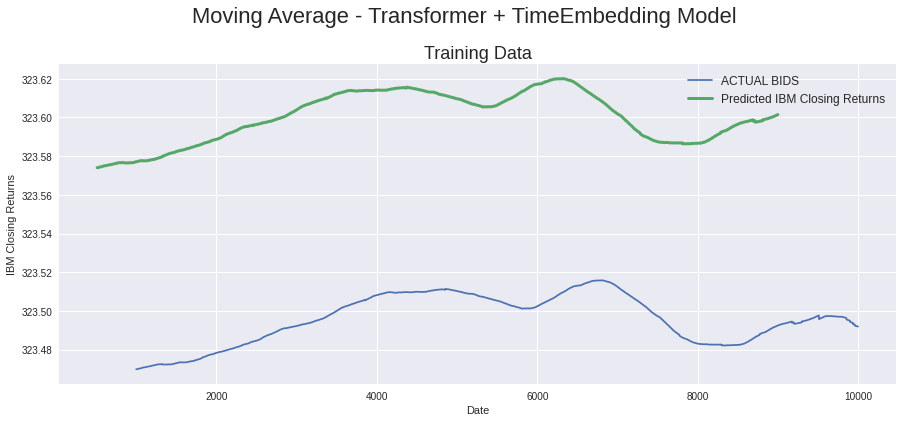

In [26]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(df['BID'], label='ACTUAL BIDS')
ax11.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred[:, 0], linewidth=3, label='Predicted Bid Prices')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)